# Notebook to replicate the analysis proposed in the Section Data of the paper

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")

import hnx
from hnx import Hypergraph
from hnx.readwrite import load_hypergraph
from hnx.communities.hypergraph_mt.model import HypergraphMT
from hnx.viz import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Input data

In [3]:
H = load_hypergraph("../test_data/hs/hs.pickle", "pickle")
print(H)

Hypergraph with 327 nodes and 7818 edges.
Distribution of hyperedge sizes: {2: 5498, 3: 2091, 4: 222, 5: 7}


### A) Higher-order degree distributions for different orders

/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/viz/plot.py:45: RuntimeWarning: divide by zero encountered in divide
  hist = hist/bin_len                 #normalize values
/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/viz/plot.py:49: RuntimeWarning: invalid value encountered in divide
  res = list(zip(bins, hist/float(sum(hist))))    #restore original bin values, norm hist
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
(0.007852691560370084, 0.015705383120740168, 0.007852691560370084, 0.031410766241480335, 0.02355807468111025, 0.031410766241480335, 0.06282153248296067, 0.058895186702775625, 0.12956941074610637, 0.12171671918573629, 0.15705383120740166, 0.19108216130233868, 0.10012181739471857, 0.045545611050146484, 0.011779037340555125, 0.0036243191817092696)
3
(0.05530931199708118, 0.13432261485005428, 0.0711119725676758, 0.07901330285297312, 0.06321064228237849, 0.09481596342356774, 0.05925997713972984, 0.06321064228237849, 0.0711119725676758, 0.07637952609120734, 0.06518597485370282, 0.057284644568405506, 0.050041758473549636, 0.02962998856986492, 0.02282606526863668, 0.005028119272461926, 0.0022575229386563745)
4
(0.242152466367713, 0.20179372197309417, 0.15246636771300448, 0.10762331838565023, 0.07174887892376682, 0.08071748878923767, 0.04035874439461883, 0.03587443946188341, 0.03139013452914798, 0.013452914798206279, 0.013452914798206279, 0.008968609865470852)
5
(0.0, nan)


<Axes: xlabel='Degree', ylabel='Frequency'>

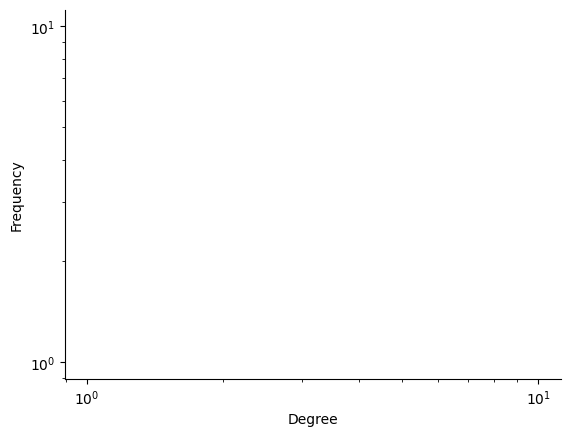

In [4]:
from hnx.viz.plot import plot_degree_distributions

plot_degree_distributions(H, max_size=5)

### B) Motifs 
(exact approach only)

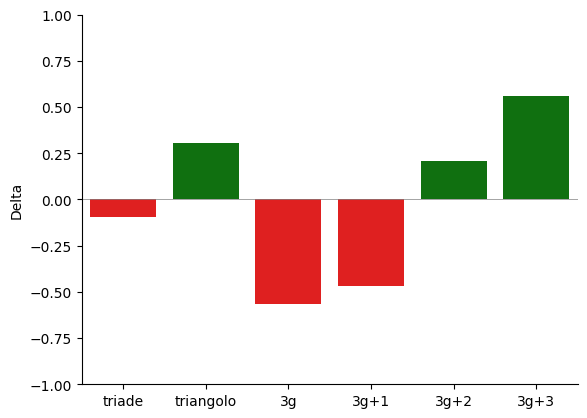

In [5]:
from hnx.motifs.motifs import compute_motifs
import seaborn as sns
import matplotlib.pyplot as plt

motifs3 = [-0.09743189457908542, 0.3057352878609137, -0.5664795273602301, -0.46704869712770475, 0.20599282046932665, 0.5617529503113179]

# plot a bar chart of the motif counts
cols = ['red' if (x < 0) else 'green' for x in motifs3]
g = sns.barplot(x=["triade", "triangolo", "3g", "3g+1", "3g+2", "3g+3"], y=motifs3, palette=cols)
g.axhline(0, color="grey", linewidth=0.5)
plt.ylim(-1, 1)
plt.ylabel("Delta")
sns.despine()
plt.savefig("motifs3.svg", bbox_inches="tight")

### C) Communities 
(one approach only) and comparison with metadata

In [6]:
# Model training
model = HypergraphMT(verbose=False)
u, w, maxL = model.fit(H, K=5, seed=10, normalizeU=False, out_inference=False, )

KeyboardInterrupt: 

In [7]:
# TODO: Marti - plot overlapping communities vs metadata (probably on the clique expansion) 
# - add draw_communities in viz

### D) Statistics of the filtered systems after applying SVH
(one statistic of Fede’s choice, for instance fraction of preserved higher-order interactions for each order after
applying the SVH filter. It is better if the dataset has at least 4 different orders, but again it is a trade-off)

In [8]:
from hnx.filters import get_svh
validated = get_svh(H, approximate_pvalue=True, mp=True)

In [9]:
import pandas as pd 

df = pd.DataFrame()

for size in validated:
    if size < 5:
        data = validated[size]
        print(len(data))
        for d in range(data.shape[0]):
            df = df.append({'size': size, 'fdr': 'Total number of interactions'}, ignore_index=True)
        data = data[data['fdr']]
        print(len(data))
        for d in range(data.shape[0]):
            df = df.append({'size': size, 'fdr': 'Number of validated interactions'}, ignore_index=True)

5498
1217
2091
518
222
62


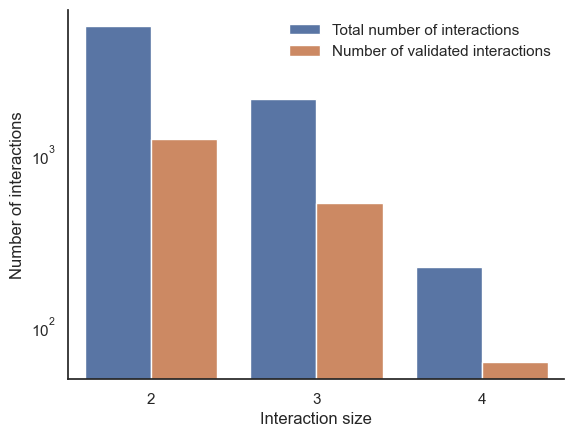

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
g = sns.countplot(data=df, x="size", hue="fdr")
plt.ylabel("Number of interactions")
plt.yscale("log")
plt.xlabel("Interaction size")
sns.despine()

plt.legend(frameon=False)

### E) Ability of the sampling method to reproduce one measure 
(one centrality measure distribution not covered so far)

In [11]:
import random
import seaborn as sns
from scipy.stats import gaussian_kde

from hnx.communities.hy_mmsbm.model import HyMMSBM
from hnx.generation.hy_mmsbm_sampling import HyMMSBMSampler
from hnx.measures.sub_hypergraph_centrality import subhypergraph_centrality

In [12]:
SEED = 112233
np.random.seed(SEED)
random.seed(SEED)

# First, infer generative parameters utilizing Hy-MMSBM.
model = HyMMSBM(K=9, assortative=True)
model.fit(H, n_iter=100)

# Sample based on these
sampler = HyMMSBMSampler(
    u = model.u,
    w = model.w,
    max_hye_size = None,
    exact_dyadic_sampling = True,
    burn_in_steps = 1000,
    intermediate_steps = 1000,
)
samples = sampler.sample(
    deg_seq = None,
    dim_seq = None,
    avg_deg = None,
    initial_hyg = H,
    allow_rescaling = False
)
sampled_h = [next(samples) for _ in range(10)]

In [13]:
samples_centr = [subhypergraph_centrality(h) for h in sampled_h]
original_centr = subhypergraph_centrality(H)

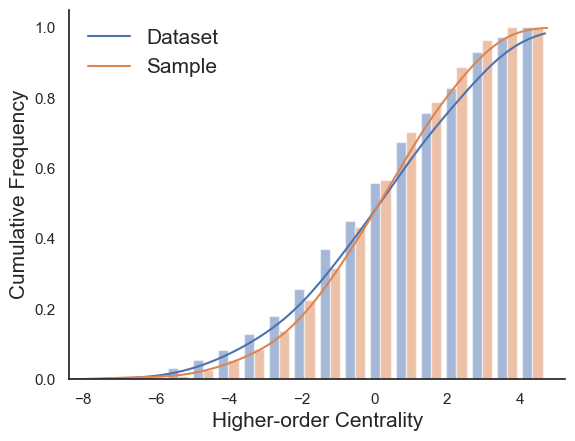

In [14]:
SAMPLE_IDX = 0
sample_centr = samples_centr[SAMPLE_IDX]

sns.set_theme(style="white")
"""
# Version 1
sns.histplot(
    {
        "Dataset": original_centr - np.mean(original_centr),
        "Sample": samples_centr[SAMPLE_IDX] - np.mean(samples_centr[SAMPLE_IDX]),
    },
    kde=True,
    cumulative=True,
    common_bins=True,
    stat="frequency",
    binwidth=0.15,
)
plt.ylabel("Cumulative Count", fontsize=15)
name="v1"


# Version 2
sns.histplot(
    {
        "Dataset": original_centr - np.mean(original_centr),
        "Sample": samples_centr[SAMPLE_IDX] - np.mean(samples_centr[SAMPLE_IDX]),
    },
    kde=True,
    cumulative=False,
    common_bins=True,
    stat="frequency",
    #binwidth=0.15,
)
plt.ylabel("Count", fontsize=15)
name="v2"

"""
# Version 3
colormap=plt.rcParams['axes.prop_cycle'].by_key()['color']
hist = plt.hist(
    [
        original_centr - np.mean(original_centr), 
        samples_centr[SAMPLE_IDX] - np.mean(samples_centr[SAMPLE_IDX])
    ],
    # label=["Dataset", "Sample"],
    cumulative=True,
    #color=['r','b'], 
    alpha=0.5,
    #rwidth=0.5, 
    bins=18, 
    density=True,
)
xmin, xmax = plt.xlim()
sns.kdeplot(
    original_centr - np.mean(original_centr),
    label="Dataset",
    cumulative=True,
    color=colormap[0],
    cut=0.,
)
sns.kdeplot(
    samples_centr[SAMPLE_IDX] - np.mean(samples_centr[SAMPLE_IDX]),
    label="Sample",
    cumulative=True,
    color=colormap[1],
    cut=1.5,
)
plt.xlim(xmin, xmax)

plt.ylabel("Cumulative Frequency", fontsize=15)
name="v3"


"""
# Version 4
colormap=plt.rcParams['axes.prop_cycle'].by_key()['color']
sns.kdeplot(
    original_centr - np.mean(original_centr),
    label="Dataset", 
    fill=True,
    cumulative=False,
    color=colormap[0],
)
sns.kdeplot(
    samples_centr[SAMPLE_IDX] - np.mean(samples_centr[SAMPLE_IDX]),
    label="Sample", 
    fill=True,
    cumulative=False,
    color=colormap[1],
)
plt.ylabel("Frequency", fontsize=15)
name="v4"
"""


sns.despine()

plt.xlabel("Higher-order Centrality", fontsize=15)

plt.legend(frameon=False, labels=["Dataset", "Sample"], fontsize=15, loc="upper left")
plt.savefig(f"./sampling_and_centrality_{name}.pdf")

### F) Temporal higher-order properties
one plot from the work of Luca (let us produce an alternative figure with respect to the arXiv. It should be a figure less cool, we keep the cool figure for the original work (one centrality measure distribution not covered so far)

In [36]:
correlation_by_order = np.load("./_example_data/temporal_correlations.npy")

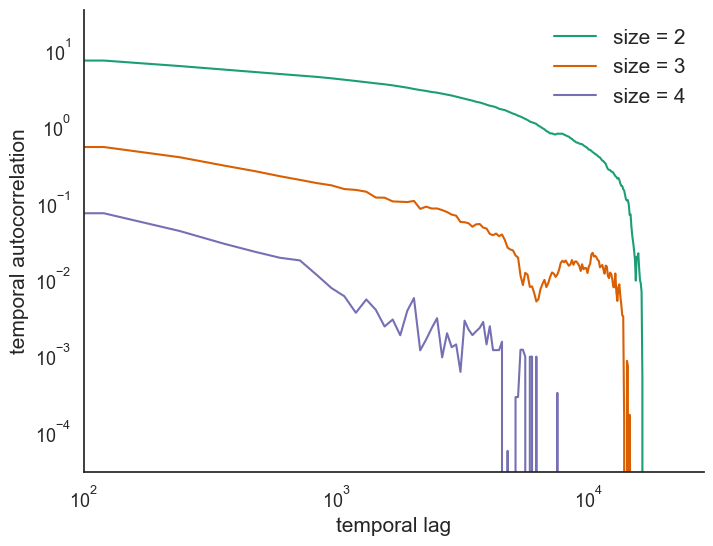

In [44]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

for d in range(3):
    ax.plot(range(0,1440*20,6*20),correlation_by_order[d,:], label="size = %s" % (d+2),
                color=plt.cm.Dark2(d))

ax.set_xlabel("temporal lag",fontsize=15)
ax.set_ylabel("temporal autocorrelation",fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)

ax.loglog()
ax.set_xlim(left=100,right=1441*20)

ax.legend(fontsize=15,frameon=False)
sns.despine()

plt.show()

### G) Statistics of a higher-order spreading process run on top of it 
(e.g. number of infected individuals as a function of time for some parameters lambda pairwise and triangles (please write the value of the parameters in the main text or in the caption). I suggest we choose a social system, because otherwise this does not make sense

In [45]:
social_contagion_data = np.load("./_example_data/social_contagion.npy")

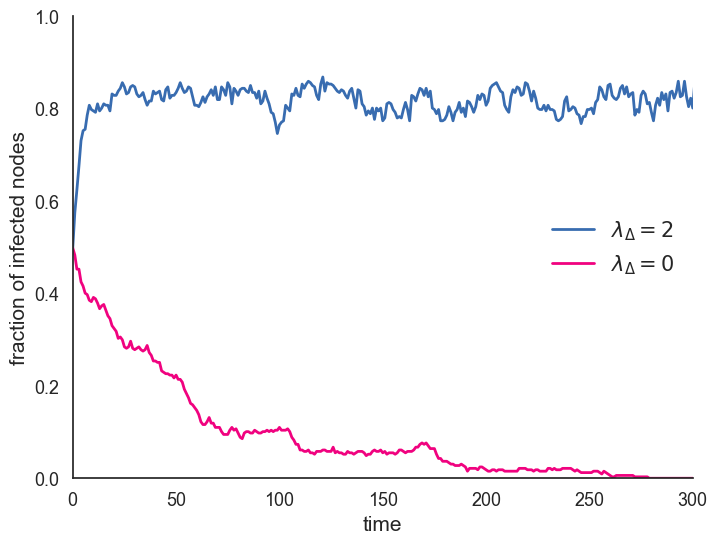

In [46]:
# We plot the results
fig, ax = plt.subplots(figsize=(8, 6))

T = 500
ax.plot(range(T),social_contagion_data[:,0], 
        lw=2, c=plt.cm.Accent(4),
        label="$\lambda_\Delta = 2$")
ax.plot(range(T),social_contagion_data[:,1], 
        lw=2, c=plt.cm.Accent(5),
        label="$\lambda_\Delta = 0$")

ax.set_xlim(0,300)
ax.set_ylim(0,1)
ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_xlabel("time", fontsize=15)
ax.set_ylabel("fraction of infected nodes", fontsize=15)
ax.legend(fontsize=15, frameon=False, loc="right")
sns.despine()
plt.show()

### H) 2 or 3 of different visualizations 
chosen by Francesco and Martina.

In [47]:
from hnx.readwrite.loaders import load_high_school
H = load_high_school("../test_data/hs/hs.json", filter_by_class=['2BIO2', '2BIO3'])
print(H)

Hypergraph with 73 nodes and 1666 edges.
Distribution of hyperedge sizes: {2: 1059, 3: 547, 4: 58, 5: 2}


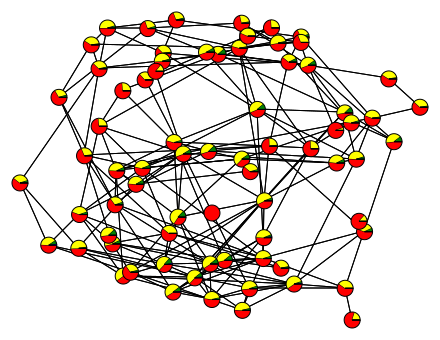

In [58]:
from hnx.viz.draw_pie import draw_pie
from IPython.display import SVG

SVG(draw_pie(H, num_edges=200))

In [312]:
from hnx.filters import get_svh

hs_svh = get_svh(H, approximate_pvalue=True, mp=True)

In [338]:
e4 = hs_svh[4]
e4 = e4[e4['fdr']]
lim = e4['pvalue']
lim = list(lim)
lim = list(sorted(lim))
print(lim)
lim = lim[3]

[1.7476793314781848e-13, 6.087861861602061e-11, 7.104492383003577e-10, 7.222002313850705e-09, 3.6406034077450105e-07, 4.859228967489003e-07, 8.05946252278273e-07, 9.598837894193928e-07]


In [339]:
edges = []
lim = float(lim)

for size in hs_svh:
    for i in range(len(hs_svh[size])):
        a = float(hs_svh[size]['pvalue'][i])
        b = bool(hs_svh[size]['fdr'][i])
        if a <= lim and b:
            edges.append(hs_svh[size]['edge'][i])

print(len(edges))

H2 = Hypergraph(edges)
lcc = H2.largest_component()
H2 = H2.subhypergraph(lcc)


77


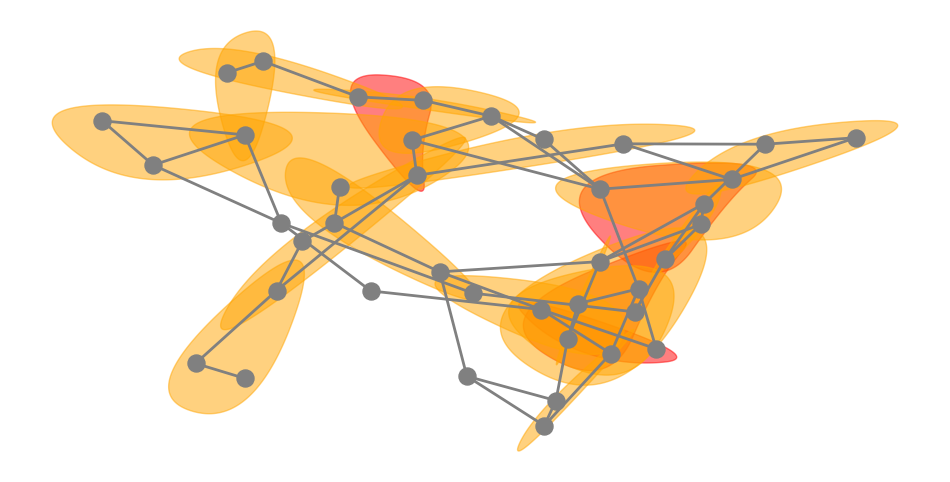

In [340]:
figsize = (12,6)
plt.figure(figsize = figsize)
draw_HG(H2, link_color='grey', node_color='gray', hyperlink_color_by_order = {2:'orange', 3:'r'})

In [29]:
# TODO: Francesco and Marti

# MC: it would be nice if one plot is the representation of the hypernetwork with the hypergraph visualization 